


[Dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set)

[fuzzy-c-means](https://pypi.org/project/fuzzy-c-means/)



In [39]:
!pip install fuzzy-c-means

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import pandas as pd
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
from fcmeans import FCM
import matplotlib.pyplot as plt
import random

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
# Removendo a primeira linha do dataset contendo o nome dos atributos
!sed 1d "/content/gdrive/MyDrive/Reconhecimento de Padrões/not-supervisioned/diabetes.csv" > dataset.csv

# Colunas dos dados
!cut dataset.csv -d"," -f1-8 > data.csv

#Coluna dos rótulos
!cut dataset.csv -d"," -f9 > labels.lab

In [43]:
# # Removendo a primeira linha do dataset contendo o nome dos atributos
# !sed 1d "/content/gdrive/MyDrive/Reconhecimento de Padrões/not-supervisioned/heart.csv" > dataset.csv

# # Colunas dos dados
# !cut dataset.csv -d"," -f1-13 > data.csv

# #Coluna dos rótulos
# !cut dataset.csv -d"," -f14 > labels.lab

In [44]:
# Carregamento dos dados
def loadData(f_data="data.csv",f_labels="labels.lab"):
     X = np.loadtxt(f_data,delimiter=",")

     y  = open(f_labels,"r").readlines()

     y = [1 if i =="1\n" else 0 for i in y]

     y = np.array(y)
     
    #  print((y[y == 0]).shape)
    #  print((y[y == 1]).shape)
     return X, y

In [45]:
def standardizeData(data,method="min"):
  # Transpoe a matriz de dados invertendo linhas e colunas
  data_T = data.T

  # Cria uma nova estrutura de dados para armazenar os valores normalizados
  new_data_T = []

  if method == "min": # Normaliza os valores pelo min e max
    for i in data_T:
      new_data_T.append(((i - np.min(i)) / (np.max(i) - np.min(i))))

  elif method == "std":  # Normaliza pelo desvio padrão
    for i in data_T:
      new_data = new_data_T.append((i - np.mean(i)) / ((np.std(i, ddof=1))**2))

  # Retorna a nova matriz normalizada no formato original
  return np.array(new_data_T).T 

In [46]:
# Divisão do dataset em conjuntos de treinamento e teste, proporção 2/3
def dataSplit(X,y,test_size=0.33,shuffle=True):
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random.randint(10,48),shuffle=shuffle) 
   return X_train, X_test, y_train, y_test

In [47]:
def printInformation(acc, cm, tpr, tnr,silhouette_avg,fisher):
  print("\n========================Critério Externo==================================")
  print(f"Accuracy: {acc}")
  print(f"True Positive Rating: {tpr}")
  print(f"True Negative Rating: {tnr}")
  print(f"\nConfusion Matrix\n {cm}")

  print("\n========================Critério Interno==================================")
  print(f"Silhouete Mean: {silhouette_avg}" )
  print(f"Fisher: {fisher}" )

In [48]:
def plotClustering(X, y_pred, centers):
  plt.figure()

  plt.scatter(centers[:, 0], centers[:, 1], c="red", marker='*', s=150)
  plt.scatter(X[:, 0], X[:, 1], c=y_pred)
  plt.title("Dados associados aos clusters")

  plt.show()

In [49]:
def fisherCalculate(X_test,y_pred):
   m1 = X_test[y_pred==0].mean()
   m2 = X_test[y_pred==1].mean()
   s1 = X_test[y_pred==0].std(ddof=1)
   s2 = X_test[y_pred==1].std(ddof=1)
   fisher =  (abs(m1 - m2) ** 2) / ((s1 ** 2) + (s2 ** 2))
   return fisher

In [50]:
def trainModels(variance, model, name):
  # Carregamento dos dados
  X,y = loadData()

  # Normalização dos dados
  X = standardizeData(X)
  
  pca = PCA(n_components=variance, svd_solver='full')

  new_dataset = pca.fit_transform(np.copy(X), y)
  X_train, X_test, y_train, y_test = dataSplit(new_dataset, y)

  model.fit(X_train)
  predictions = model.predict(X_test)
  y_pred = predictions.reshape(-1)


  print(X_train.shape)
  print(np.array(y_train).shape)
  print(X_test.shape)
  print(np.array(y_test).shape)


  # Avaliação de performance com critério externo usando a matriz de confusão
  # e a acurácia 
  
  print("Modelo: ", name)
  print("Variância: ", variance)
  print("Número de componentes: ", pca.n_components_)

  if name == 'Fuzzy C-Means':
    centers = model.centers
  else:
    distances = model.transform(X_test)
    centers = model.cluster_centers_

  
  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
  silhouette_avg = silhouette_score(X_test, y_pred)

  # Fisher
  fisher =  fisherCalculate(X_test,y_pred)

  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  acc = (tn + tp) / (tn + fp + fn +tp)
  tpr = tp / (tp + fn)
  tnr = tn / (tn + fp)

  printInformation(acc,cm,tpr,tnr,silhouette_avg,fisher)
  plotClustering(X_test, y_pred, centers)
  print("\n........................................................................\n")



(514, 5)
(514,)
(254, 5)
(254,)
Modelo:  K-Means
Variância:  0.75
Número de componentes:  5

========================Critério Externo==================================
Accuracy: 0.6299212598425197
True Positive Rating: 0.4523809523809524
True Negative Rating: 0.7176470588235294

Confusion Matrix
 [[122  48]
 [ 46  38]]

========================Critério Interno==================================
Silhouete Mean: 0.2966391632052712
Fisher: 0.11950324899764779


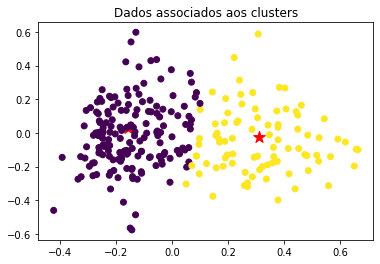


........................................................................

(514, 5)
(514,)
(254, 5)
(254,)
Modelo:  Fuzzy C-Means
Variância:  0.75
Número de componentes:  5

========================Critério Externo==================================
Accuracy: 0.6653543307086615
True Positive Rating: 0.6222222222222222
True Negative Rating: 0.6890243902439024

Confusion Matrix
 [[113  51]
 [ 34  56]]

========================Critério Interno==================================
Silhouete Mean: 0.29838774903627113
Fisher: 0.14843706080209165


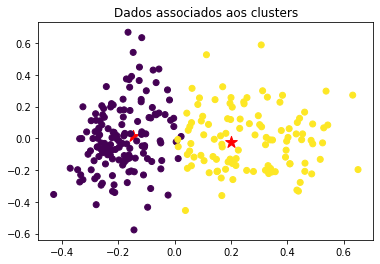


........................................................................

(514, 6)
(514,)
(254, 6)
(254,)
Modelo:  K-Means
Variância:  0.9
Número de componentes:  6

========================Critério Externo==================================
Accuracy: 0.33858267716535434
True Positive Rating: 0.5595238095238095
True Negative Rating: 0.22941176470588234

Confusion Matrix
 [[ 39 131]
 [ 37  47]]

========================Critério Interno==================================
Silhouete Mean: 0.28327140924144273
Fisher: 0.09801086138437277


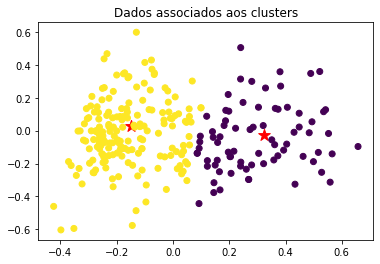


........................................................................

(514, 6)
(514,)
(254, 6)
(254,)
Modelo:  Fuzzy C-Means
Variância:  0.9
Número de componentes:  6

========================Critério Externo==================================
Accuracy: 0.3228346456692913
True Positive Rating: 0.4375
True Negative Rating: 0.25316455696202533

Confusion Matrix
 [[ 40 118]
 [ 54  42]]

========================Critério Interno==================================
Silhouete Mean: 0.25500785303553214
Fisher: 0.07918241397623138


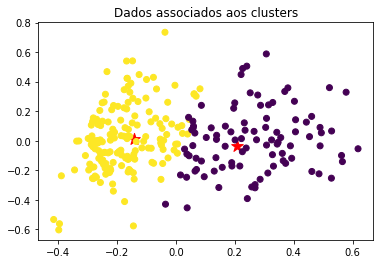


........................................................................

(514, 8)
(514,)
(254, 8)
(254,)
Modelo:  K-Means
Variância:  0.99
Número de componentes:  8

========================Critério Externo==================================
Accuracy: 0.3110236220472441
True Positive Rating: 0.42857142857142855
True Negative Rating: 0.2529411764705882

Confusion Matrix
 [[ 43 127]
 [ 48  36]]

========================Critério Interno==================================
Silhouete Mean: 0.2816952250226745
Fisher: 0.06779598999486572


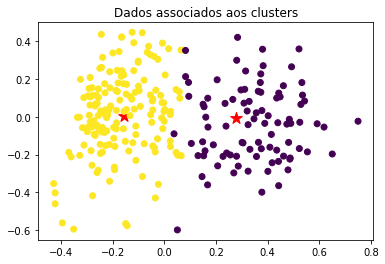


........................................................................

(514, 8)
(514,)
(254, 8)
(254,)
Modelo:  Fuzzy C-Means
Variância:  0.99
Número de componentes:  8

========================Critério Externo==================================
Accuracy: 0.6653543307086615
True Positive Rating: 0.5301204819277109
True Negative Rating: 0.7309941520467836

Confusion Matrix
 [[125  46]
 [ 39  44]]

========================Critério Interno==================================
Silhouete Mean: 0.23929478953177843
Fisher: 0.03573941004112237


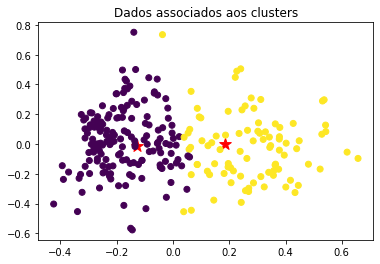


........................................................................



In [51]:
def main():
  variances = [0.75, 0.90, 0.99]

  for variance in variances:
    trainModels(variance, KMeans(n_clusters=2, random_state=0), "K-Means");
    trainModels(variance, FCM(n_clusters=2), "Fuzzy C-Means");

if __name__ == "__main__":
  main()